## Kết nối Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/PBL5/

/content/drive/MyDrive/PBL5


## Giải nén

In [ ]:
import zipfile
import os

# Đường dẫn tới file zip
zip_path = 'garbage-dataset.zip'  # thay bằng đường dẫn tới file zip nếu cần

# Đường dẫn giải nén
extract_path = ''

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Giải nén thành công vào thư mục:", extract_path)


Giải nén thành công vào thư mục: 


## Hiển thị ảnh ban đầu

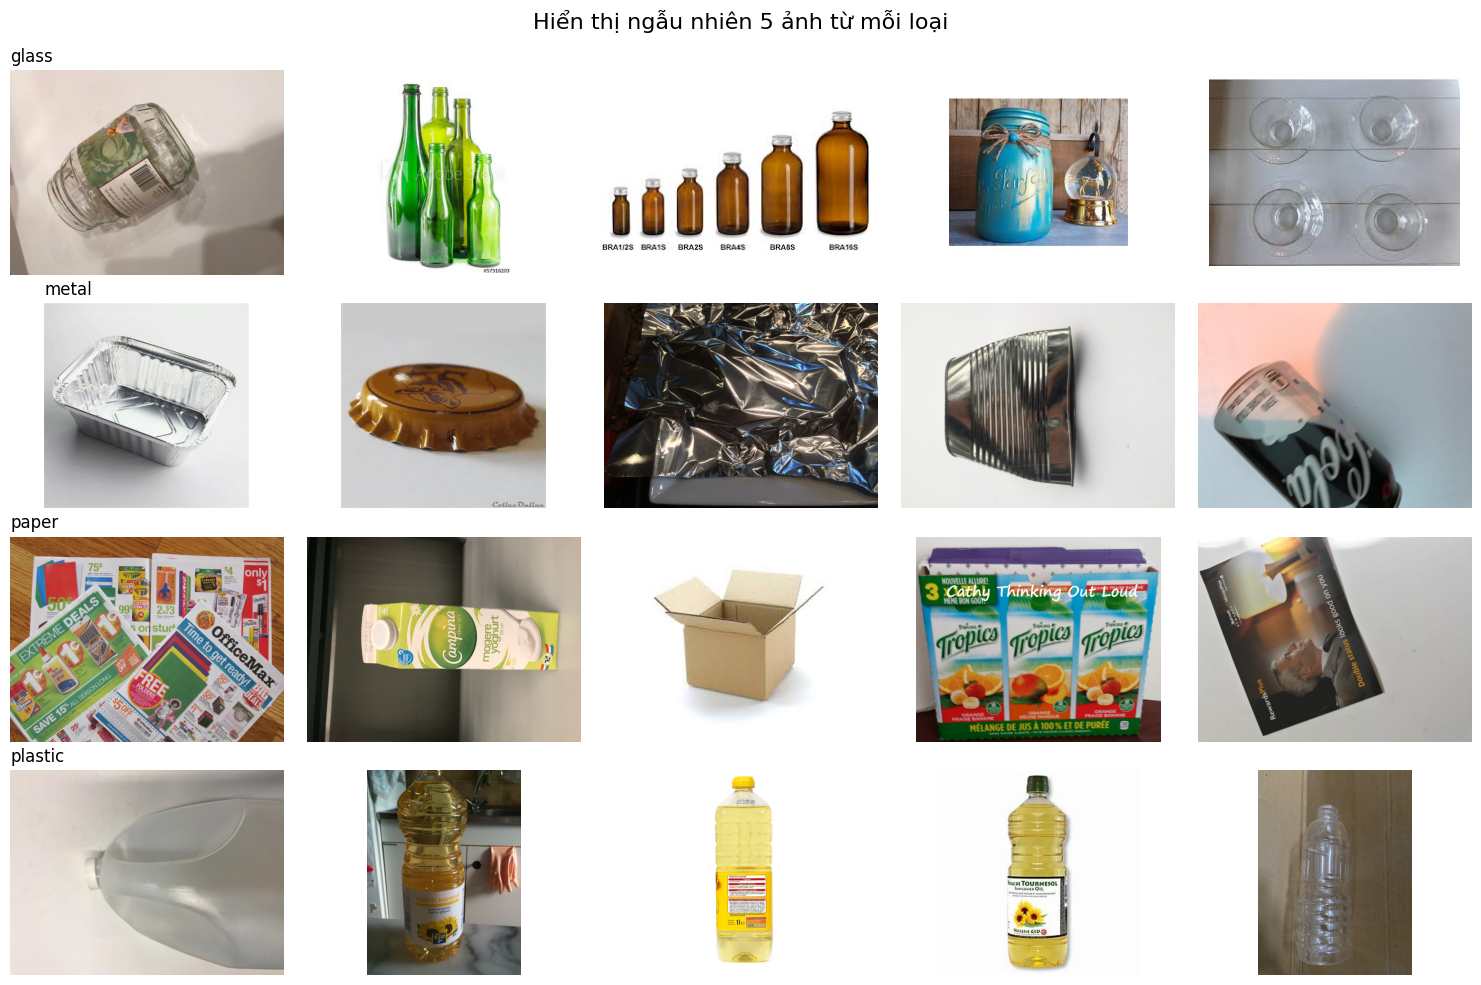

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Đường dẫn tới thư mục chính chứa ảnh
base_dir = 'garbage-dataset'

# Tên các thư mục con tương ứng với từng loài vật
categories = ['glass', 'metal', 'paper', 'plastic']

# Số ảnh ngẫu nhiên cần hiển thị mỗi loại
num_images = 5

# Tạo lưới hiển thị ảnh: 4 hàng (loài vật), mỗi hàng 5 ảnh
fig, axes = plt.subplots(nrows=4, ncols=num_images, figsize=(15, 10))
fig.suptitle("Hiển thị ngẫu nhiên 5 ảnh từ mỗi loại", fontsize=16)

for row, category in enumerate(categories):
    folder_path = os.path.join(base_dir, category)
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(images, min(num_images, len(images)))  # Lấy ngẫu nhiên

    for col, img_name in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(category, fontsize=12, loc='left')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Chia train/val/test

In [ ]:
import tensorflow as tf

def is_valid_image(fp):
    try:
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3)
        return True
    except:
        return False


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

categories = ['glass', 'metal', 'paper', 'plastic']
base_dir = 'garbage-dataset'

file_paths = []
labels = []

for idx, cls in enumerate(categories):
    cls_dir = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            fpath = os.path.join(cls_dir, fname)
            if is_valid_image(fpath):  # chỉ lấy ảnh hợp lệ
                file_paths.append(fpath)
                labels.append(idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Chia train (70%) - val (15%) - test (15%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


** Kiểm tra phân phối **

In [ ]:
# Kiểm tra phân bố nhãn trong train và val
import numpy as np

print("Train label distribution:")
unique_train, counts_train = np.unique(train_labels, return_counts=True)
for label, count in zip(unique_train, counts_train):
    print(f"Class {label}: {count} samples")

print("\nValidation label distribution:")
unique_val, counts_val = np.unique(val_labels, return_counts=True)
for label, count in zip(unique_val, counts_val):
    print(f"Class {label}: {count} samples")

print("\nTest label distribution:")
unique_test, counts_test = np.unique(test_labels, return_counts=True)
for label, count in zip(unique_test, counts_test):
    print(f"Class {label}: {count} samples")


Train label distribution:
Class 0: 2480 samples
Class 1: 1002 samples
Class 2: 2433 samples
Class 3: 1705 samples

Validation label distribution:
Class 0: 532 samples
Class 1: 215 samples
Class 2: 521 samples
Class 3: 365 samples

Test label distribution:
Class 0: 532 samples
Class 1: 214 samples
Class 2: 522 samples
Class 3: 366 samples


## Quá trình train

** Xử lý **

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

def process_path(fp, lbl):
    img = tf.io.read_file(fp)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    return img, lbl

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])


def augment_and_preprocess(img, lbl):
    img = data_augmentation(img)
    img = preprocess_input(img)
    lbl = tf.one_hot(lbl, NUM_CLASSES)
    return img, lbl

def preprocess_only(img, lbl):
    img = preprocess_input(img)
    lbl = tf.one_hot(lbl, NUM_CLASSES)
    return img, lbl

def make_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(preprocess_only, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(999) if augment else ds
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, augment=True)
val_ds = make_dataset(val_paths, val_labels, augment=False)
test_ds = make_dataset(test_paths, test_labels, augment=False)


** Trực quan ảnh sau khi Augmentation **

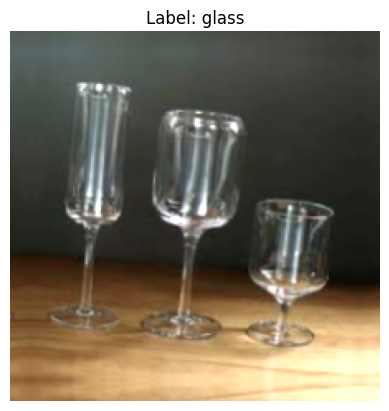

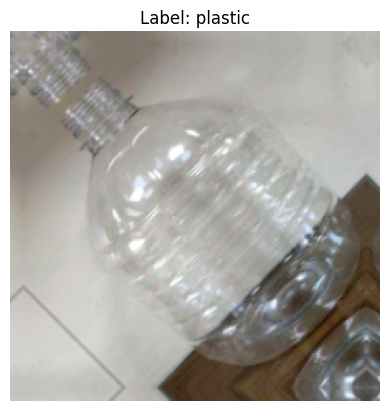

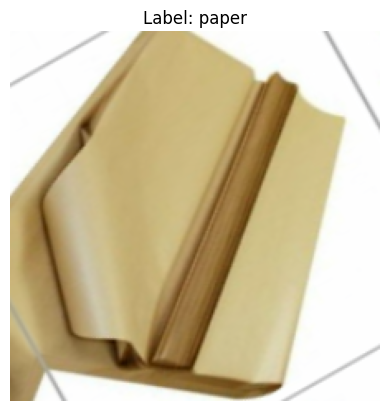

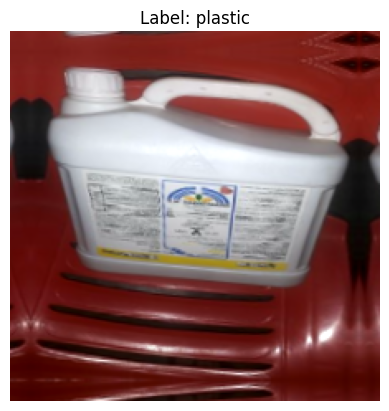

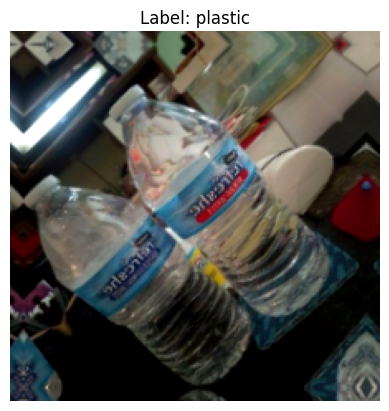

In [ ]:
import matplotlib.pyplot as plt

sample_ds = make_dataset(train_paths[:5], train_labels[:5], augment=True)

for images, labels in sample_ds.take(1):
    for i in range(len(images)):
        img = images[i].numpy()
        img = (img - img.min()) / (img.max() - img.min())  # chuẩn hóa lại để hiển thị
        label = tf.argmax(labels[i]).numpy()
        plt.imshow(img)
        plt.title(f"Label: {categories[label]}")
        plt.axis("off")
        plt.show()


** Giai đoạn 1: Huấn luyện head **

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
import os


base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# === Scheduler cho giai đoạn 1 ===
steps_per_epoch = len(train_ds)
lr_schedule = CosineDecay(initial_learning_rate=1e-3, decay_steps=steps_per_epoch * 20, alpha=1e-2)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

callbacks = [
    ModelCheckpoint("outputs/checkpoints/best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
  )

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6499 - loss: 1.1205
Epoch 1: val_accuracy improved from -inf to 0.90080, saving model to outputs/checkpoints/best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 167s 555ms/step - accuracy: 0.6504 - loss: 1.1195 - val_accuracy: 0.9008 - val_loss: 0.5860
Epoch 2/20
237/239 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8453 - loss: 0.6815
Epoch 2: val_accuracy improved from 0.90080 to 0.92835, saving model to outputs/checkpoints/best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 160s 429ms/step - accuracy: 0.8456 - loss: 0.6811 - val_accuracy: 0.9284 - val_loss: 0.5291
Epoch 3/20
237/239 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8914 - loss: 0.6086
Epoch 3: val_accuracy improved from 0.92835 to 0.93141, saving model to outputs/checkpoints/best_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 117s 433ms/step - accuracy: 0.8915 - loss: 0.6084 - val_accuracy: 0.9314 - val_loss: 0.507

** Giai đoạn 2: Fine-tune phần trên của base_model **

In [ ]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Scheduler mới cho 70 epoch fine-tune
lr_schedule_finetune = CosineDecay(initial_learning_rate=1e-4, decay_steps=steps_per_epoch * 70, alpha=1e-2)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule_finetune, weight_decay=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=70,
    callbacks=callbacks
  )

model.save("outputs/checkpoints/final_model.keras")

Epoch 1/70
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8853 - loss: 0.5902
Epoch 1: val_accuracy did not improve from 0.95285
239/239 ━━━━━━━━━━━━━━━━━━━━ 198s 571ms/step - accuracy: 0.8854 - loss: 0.5901 - val_accuracy: 0.9308 - val_loss: 0.4939
Epoch 2/70
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9463 - loss: 0.4867
Epoch 2: val_accuracy did not improve from 0.95285
239/239 ━━━━━━━━━━━━━━━━━━━━ 121s 445ms/step - accuracy: 0.9463 - loss: 0.4866 - val_accuracy: 0.9351 - val_loss: 0.4806
Epoch 3/70
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9473 - loss: 0.4789
Epoch 3: val_accuracy did not improve from 0.95285
239/239 ━━━━━━━━━━━━━━━━━━━━ 142s 446ms/step - accuracy: 0.9474 - loss: 0.4787 - val_accuracy: 0.9498 - val_loss: 0.4599
Epoch 4/70
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9646 - loss: 0.4495
Epoch 4: val_accuracy improved from 0.95285 to 0.95897, saving model to outputs/checkpoints/best_model.keras
239/239 ━━━━━━━━━━━━━━━

** Biểu đồ quá trình huấn luyện **

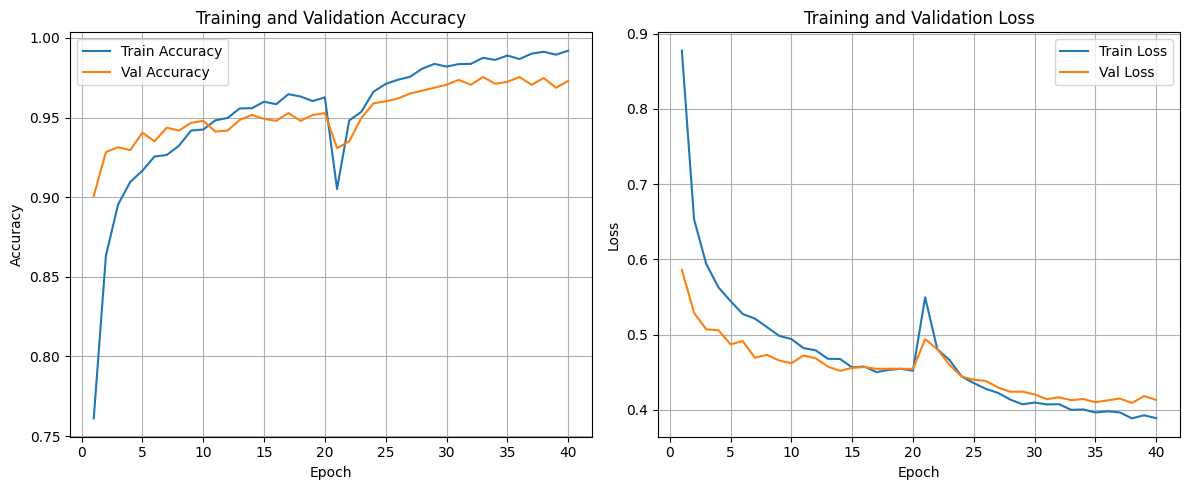

In [ ]:
import matplotlib.pyplot as plt

def plot_history(*histories):
    history_combined = {
        "accuracy": [],
        "val_accuracy": [],
        "loss": [],
        "val_loss": []
    }

    for history in histories:
        for key in history_combined:
            history_combined[key] += history.history.get(key, [])

    epochs = range(1, len(history_combined["accuracy"]) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_combined["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history_combined["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_combined["loss"], label="Train Loss")
    plt.plot(epochs, history_combined["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history, history_finetune)

** Đánh giá trên tập test **

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

# Load model tốt nhất nếu cần
model = tf.keras.models.load_model("outputs/checkpoints/best_model_98.keras")

# Lấy nhãn thực và nhãn dự đoán
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    true_labels = tf.argmax(labels, axis=1).numpy()
    pred_labels = tf.argmax(preds, axis=1).numpy()

    y_true.extend(true_labels)
    y_pred.extend(pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Hiển thị báo cáo đánh giá
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=categories, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

       glass     0.9944    0.9962    0.9953       532
       metal     0.9907    1.0000    0.9953       214
       paper     0.9962    0.9962    0.9962       522
     plastic     0.9917    0.9836    0.9877       366

    accuracy                         0.9939      1634
   macro avg     0.9933    0.9940    0.9936      1634
weighted avg     0.9939    0.9939    0.9939      1634


=== Confusion Matrix ===
[[530   0   0   2]
 [  0 214   0   0]
 [  0   1 520   1]
 [  3   1   2 360]]


** Xem những ảnh dự đoán sai **

## Inference

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load mô hình đã huấn luyện
model = tf.keras.models.load_model("outputs/checkpoints/best_model_98.keras")

# Kích thước ảnh và nhãn
IMG_SIZE = (224, 224)
categories = ['glass', 'metal', 'paper', 'plastic']

def predict_image(img_path):
    # Load và resize ảnh
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)

    # Cast và chuẩn hóa theo MobileNetV3
    img_array = tf.cast(img_array, tf.float32)
    img_array = preprocess_input(img_array)

    # Thêm batch dimension
    img_batch = tf.expand_dims(img_array, axis=0)

    # Dự đoán
    preds = model.predict(img_batch)
    pred_class = np.argmax(preds[0])
    confidence = np.max(preds[0])

    # Hiển thị kết quả
    plt.imshow(img)
    plt.title(f"Dự đoán: {categories[pred_class]} ({confidence * 100:.2f}%)")
    plt.axis("off")
    plt.show()

# Dùng thử
# predict_image("test_images/glass.jpg")


In [ ]:
import os

def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Ảnh: {filename}")
            predict_image(os.path.join(folder_path, filename))

# Ví dụ dùng
predict_folder("test_images")


Output hidden; open in https://colab.research.google.com to view.

## Chuyển .keras sang .tflite

In [ ]:
import tensorflow as tf

# Load model đã huấn luyện
model = tf.keras.models.load_model("outputs/checkpoints/best_model_98.keras")

# Convert sang TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Lưu file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Đã chuyển sang model.tflite")


Saved artifact at '/tmp/tmpla9bfk8w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133707044191312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027038672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027040784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027041168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027040400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027039824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027040976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027042128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027040592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133707027041360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1337070270432

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# ——— Cấu hình ———
MODEL_PATH = "model.tflite"
IMG_SIZE = (224, 224)
CATEGORIES = ['glass', 'metal', 'paper', 'plastic']

# ——— Load model TFLite ———
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def custom_preprocess_image(img_path, img_size=(224, 224)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(img_size)
    img_array = np.array(img, dtype=np.float32)
    # Chuẩn hóa về [-1, 1]
    img_array = (img_array / 127.5) - 1.0
    return np.expand_dims(img_array, axis=0)

def predict_image_tflite(img_path):
    input_data = custom_preprocess_image(img_path, IMG_SIZE)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    pred_idx = np.argmax(output_data)
    confidence = output_data[pred_idx]

    # Hiển thị kết quả
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Dự đoán: {CATEGORIES[pred_idx]} ({confidence * 100:.2f}%)")
    plt.axis("off")
    plt.show()

    return CATEGORIES[pred_idx], float(confidence)

In [ ]:
import os

def predict_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Ảnh: {filename}")
            predict_image_tflite(os.path.join(folder_path, filename))

# Ví dụ dùng
predict_folder("test_images")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from PIL import Image

# Cấu hình
IMG_SIZE = (224, 224)
NUM_CLASSES = 4
class_names = ['glass', 'metal', 'paper', 'plastic']

# Load mô hình Keras
model = tf.keras.models.load_model("outputs/checkpoints/best_model_98.keras")

# Hàm xử lý ảnh và phân loại
def classify_image(image_path="rubbish.jpg"):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)

    # Chuẩn hóa theo MobileNetV3: [-1, 1]
    img_array = preprocess_input(img_array)
    input_data = np.expand_dims(img_array, axis=0)

    # Dự đoán
    preds = model.predict(input_data)
    pred_class = np.argmax(preds[0])
    confidence = np.max(preds[0])

    return pred_class, confidence


In [ ]:
pred, conf = classify_image("test_images/glass.jpg")
print(f"Dự đoán: {class_names[pred]} ({conf*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Dự đoán: glass (93.44%)
